We'll simulate a dataset with multiple metrics and use more advanced analysis techniques.
- Scenario:
A mobile gaming app is testing two different engagement strategies:

- Strategy A (control): Current strategy
- Strategy B (treatment): New strategy with personalized push notifications

We'll track multiple metrics:

- Daily Active Users (DAU)
- Average Session Duration (in minutes)
- In-App Purchases (IAP) per user
- 7-day Retention Rate

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

np.random.seed(42)


In [6]:
# generate dataset
# modifications to group B are
# - increased the probability of a user being active from 0.5 (default for binomial distribution) to 0.55
# - retention increased from 0.6 to 0.65 of a binomial dist (like 5% increase only)

# Generate sample data
n_users = 5000
data = {
    "user_id": range(1, n_users + 1),
    "group": np.random.choice(["A", "B"], size=n_users),
    "dau": np.random.randint(0, 2, size=n_users),  # 0 or 1 for each day
    "session_duration": np.random.exponential(
        scale=15, size=n_users
    ),  # exponential distribution
    "iap": np.random.exponential(scale=0.5, size=n_users),  # exponential distribution
    "retained": np.random.binomial(1, 0.6, size=n_users),  # binomial distribution
}

df = pd.DataFrame(data)

# Adjust values based on group
df.loc[df["group"] == "B", "dau"] = np.random.binomial(
    1, 0.55, size=len(df[df["group"] == "B"])
)
df.loc[df["group"] == "B", "session_duration"] *= 1.1
df.loc[df["group"] == "B", "iap"] *= 1.15
df.loc[df["group"] == "B", "retained"] = np.random.binomial(
    1, 0.65, size=len(df[df["group"] == "B"])
)

print(df.head())
print(df.describe())


   user_id group  dau  session_duration       iap  retained
0        1     A    0          7.504110  0.233916         1
1        2     B    0         10.582799  0.232779         0
2        3     A    0         28.918575  0.096886         1
3        4     A    0          6.232831  0.467312         1
4        5     A    1         30.562946  0.323728         1
           user_id          dau  session_duration          iap     retained
count  5000.000000  5000.000000       5000.000000  5000.000000  5000.000000
mean   2500.500000     0.523800         15.205298     0.544284     0.618400
std    1443.520003     0.499483         15.195431     0.547685     0.485828
min       1.000000     0.000000          0.000872     0.000079     0.000000
25%    1250.750000     0.000000          4.458514     0.154273     0.000000
50%    2500.500000     1.000000         10.432098     0.369615     1.000000
75%    3750.250000     1.000000         20.873263     0.757128     1.000000
max    5000.000000     1.000000 


Metric: dau
Mean A: 0.5212
Mean B: 0.5264
T-statistic: -0.3734
P-value: 0.7088
Cohen's d: 0.0106

Metric: session_duration
Mean A: 14.4001
Mean B: 16.0130
T-statistic: -3.7577
P-value: 0.0002
Cohen's d: 0.1063

Metric: iap
Mean A: 0.5048
Mean B: 0.5838
T-statistic: -5.1124
P-value: 0.0000
Cohen's d: 0.1446

Metric: retained
Mean A: 0.5907
Mean B: 0.6462
T-statistic: -4.0509
P-value: 0.0001
Cohen's d: 0.1146


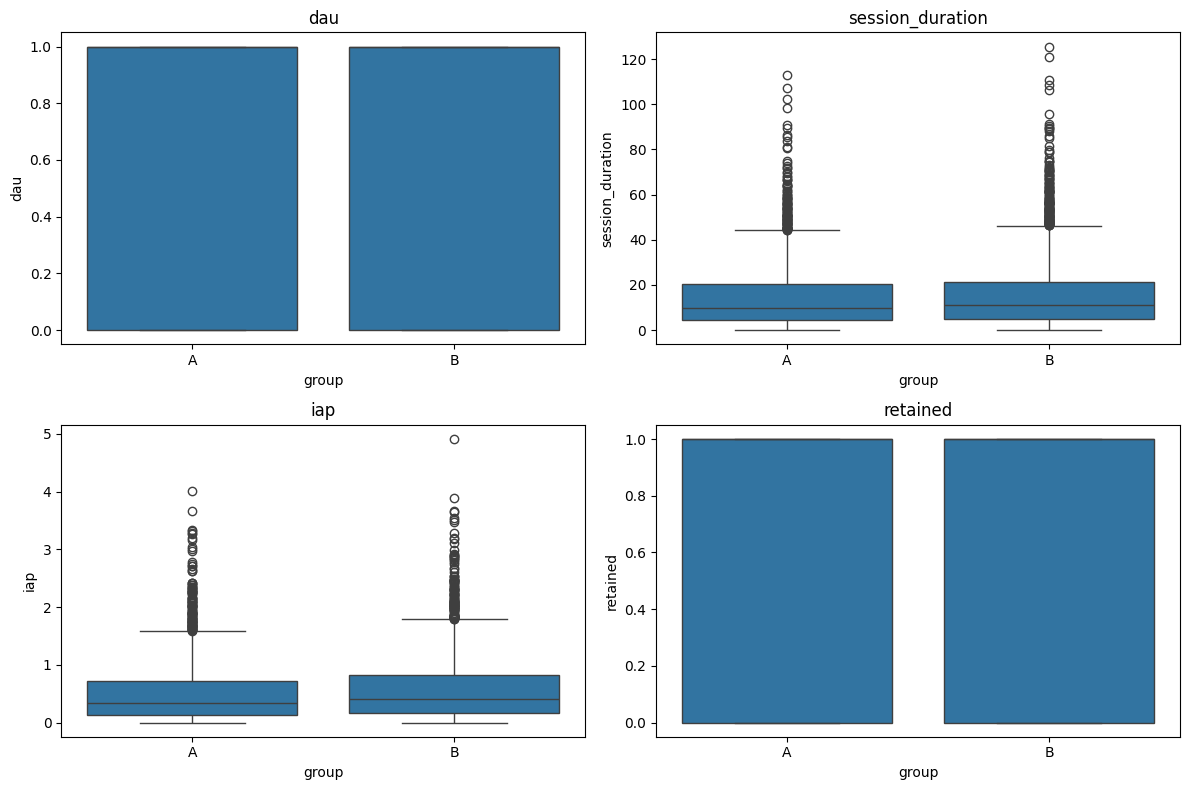

In [13]:
# implement A-B testing
def analyze_metric(df, metric):
    group_a = df[df["group"] == "A"][metric]
    group_b = df[df["group"] == "B"][metric]

    # Calculate means
    mean_a = group_a.mean()
    mean_b = group_b.mean()

    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(group_a, group_b)

    # Calculate Cohen's d for effect size
    cohens_d = (mean_b - mean_a) / np.sqrt((group_a.var() + group_b.var()) / 2)

    # Calculate confidence interval
    # ci_diff = stats.t.interval(
    #     alpha=0.95,
    #     df=len(df) - 2,
    #     loc=mean_b - mean_a,
    #     scale=stats.sem(group_b - group_a),
    # )

    return {
        "metric": metric,
        "mean_a": mean_a,
        "mean_b": mean_b,
        "t_statistic": t_statistic,
        "p_value": p_value,
        "cohens_d": cohens_d,
        # "ci_diff": ci_diff,
    }


metrics = ["dau", "session_duration", "iap", "retained"]
results = [analyze_metric(df, metric) for metric in metrics]

# Print results
for result in results:
    print(f"\nMetric: {result['metric']}")
    print(f"Mean A: {result['mean_a']:.4f}")
    print(f"Mean B: {result['mean_b']:.4f}")
    print(f"T-statistic: {result['t_statistic']:.4f}")
    print(f"P-value: {result['p_value']:.4f}")
    print(f"Cohen's d: {result['cohens_d']:.4f}")
    # print(
    #     f"95% CI of difference: ({result['ci_diff'][0]:.4f}, {result['ci_diff'][1]:.4f})"
    # )

# Visualize results
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x="group", y=metric, data=df)
    plt.title(metric)
plt.tight_layout()
plt.show()


In [8]:
# Multiple Comparison Correction
from statsmodels.stats.multitest import multipletests

# Perform Bonferroni correction
_, adjusted_p_values, _, _ = multipletests(
    [r["p_value"] for r in results], method="bonferroni"
)

print("\nAdjusted p-values (Bonferroni correction):")
for metric, adj_p in zip(metrics, adjusted_p_values):
    print(f"{metric}: {adj_p:.4f}")



Adjusted p-values (Bonferroni correction):
dau: 1.0000
session_duration: 0.0007
iap: 0.0000
retained: 0.0002


In [9]:
# subgroup analysis

# Assuming we have age data for users
df["age_group"] = pd.cut(
    np.random.randint(18, 65, size=n_users),
    bins=[0, 25, 35, 50, 100],
    labels=["18-25", "26-35", "36-50", "50+"],
)


def subgroup_analysis(df, metric, subgroup):
    results = []
    for group in df[subgroup].unique():
        subset = df[df[subgroup] == group]
        result = analyze_metric(subset, metric)
        result["subgroup"] = f"{subgroup}_{group}"
        results.append(result)
    return results


subgroup_results = []
for metric in metrics:
    subgroup_results.extend(subgroup_analysis(df, metric, "age_group"))

# Print subgroup results
for result in subgroup_results:
    print(f"\nSubgroup: {result['subgroup']}, Metric: {result['metric']}")
    print(f"Mean A: {result['mean_a']:.4f}")
    print(f"Mean B: {result['mean_b']:.4f}")
    print(f"P-value: {result['p_value']:.4f}")



Subgroup: age_group_26-35, Metric: dau
Mean A: 0.5186
Mean B: 0.5288
P-value: 0.7387

Subgroup: age_group_36-50, Metric: dau
Mean A: 0.5296
Mean B: 0.5147
P-value: 0.5453

Subgroup: age_group_50+, Metric: dau
Mean A: 0.5270
Mean B: 0.5239
P-value: 0.9065

Subgroup: age_group_18-25, Metric: dau
Mean A: 0.4976
Mean B: 0.5521
P-value: 0.1174

Subgroup: age_group_26-35, Metric: session_duration
Mean A: 14.9356
Mean B: 16.6313
P-value: 0.0874

Subgroup: age_group_36-50, Metric: session_duration
Mean A: 13.8400
Mean B: 16.0016
P-value: 0.0026

Subgroup: age_group_50+, Metric: session_duration
Mean A: 14.9046
Mean B: 15.8056
P-value: 0.2599

Subgroup: age_group_18-25, Metric: session_duration
Mean A: 13.8524
Mean B: 15.6150
P-value: 0.0914

Subgroup: age_group_26-35, Metric: iap
Mean A: 0.4773
Mean B: 0.5410
P-value: 0.0496

Subgroup: age_group_36-50, Metric: iap
Mean A: 0.5145
Mean B: 0.5920
P-value: 0.0046

Subgroup: age_group_50+, Metric: iap
Mean A: 0.5153
Mean B: 0.5919
P-value: 0.0082


In [10]:
# AB testing

In [11]:
from scipy import stats


def bayesian_ab_test_scipy(df, metric):
    group_a = df[df["group"] == "A"][metric]
    group_b = df[df["group"] == "B"][metric]

    # Calculate the posterior distribution of the difference in means
    t_statistic, p_value = stats.ttest_ind(group_b, group_a)

    # Calculate effect size (Cohen's d)
    d = (np.mean(group_b) - np.mean(group_a)) / np.sqrt(
        (np.std(group_a, ddof=1) ** 2 + np.std(group_b, ddof=1) ** 2) / 2
    )

    # Calculate the probability that B is better than A
    prob_b_better = stats.norm.cdf(d / np.sqrt(2 / len(group_a) + 2 / len(group_b)))

    return {
        "mean_diff": np.mean(group_b) - np.mean(group_a),
        "ci_95": stats.t.interval(
            0.95,
            len(group_a) + len(group_b) - 2,
            loc=np.mean(group_b) - np.mean(group_a),
            scale=stats.sem(group_b) + stats.sem(group_a),
        ),
        "prob_b_better": prob_b_better,
    }


# Perform Bayesian A/B test for each metric
bayesian_results = {}
for metric in metrics:
    result = bayesian_ab_test_scipy(df, metric)
    bayesian_results[metric] = result

# Print Bayesian results
for metric, result in bayesian_results.items():
    print(f"\nBayesian A/B Test Results for {metric}:")
    print(f"Mean difference (B - A): {result['mean_diff']:.4f}")
    print(
        f"95% Credible Interval: ({result['ci_95'][0]:.4f}, {result['ci_95'][1]:.4f})"
    )
    print(f"Probability that B is better: {result['prob_b_better']:.4f}")



Bayesian A/B Test Results for dau:
Mean difference (B - A): 0.0053
95% Credible Interval: (-0.0339, 0.0444)
Probability that B is better: 0.6041

Bayesian A/B Test Results for session_duration:
Mean difference (B - A): 1.6129
95% Credible Interval: (0.4247, 2.8012)
Probability that B is better: 0.9961

Bayesian A/B Test Results for iap:
Mean difference (B - A): 0.0790
95% Credible Interval: (0.0362, 0.1218)
Probability that B is better: 0.9998

Bayesian A/B Test Results for retained:
Mean difference (B - A): 0.0556
95% Credible Interval: (0.0175, 0.0936)
Probability that B is better: 0.9979
